In [1]:
# ===============================
# Section 0: Load Raw VQA-RAD Data
# ===============================
import json

with open(r"D:\UM\WOA7015 ADVANCE MACHINE LEARNING\AA\VQA_RAD Dataset Public.json", "r") as f:
    raw_data = json.load(f)

print(type(raw_data))
print(raw_data[0].keys())

# fullfil dataset loading / understanding

# ===============================
# Section 1: Define Raw Test Data
# ===============================
from split import split_by_qid

train_data, test_data = split_by_qid(raw_data)
train_qids = set(x["qid_linked_id"] for x in train_data)
test_qids  = set(x["qid_linked_id"] for x in test_data)

print(len(train_data), len(test_data))
print("Overlap:", len(train_qids & test_qids))

# proper data split / no leakage

<class 'list'>
dict_keys(['qid', 'phrase_type', 'qid_linked_id', 'image_case_url', 'image_name', 'image_organ', 'evaluation', 'question', 'question_rephrase', 'question_relation', 'question_frame', 'question_type', 'answer', 'answer_type'])
1810 438
Overlap: 0


In [2]:
# ===============================
# Section 2: Load Raw Dataset Object
# ===============================
from dataset import VQARADDataset

raw_dataset = VQARADDataset(
    json_path=r"D:\UM\WOA7015 ADVANCE MACHINE LEARNING\AA\VQA_RAD Dataset Public.json",
    image_dir=r"D:\UM\WOA7015 ADVANCE MACHINE LEARNING\AA\VQA_RAD Image Folder"
)

# Display
sample = raw_dataset[0]
print("Question:", sample["question"])
print("Answer:", sample["answer"], ", Type:", sample["answer_type"])
print("Question Type:", sample["question_type"], ", Image Organ:", sample["image_organ"])
print("Image shape:", sample["image"].shape)

# dataset inspection / qualitative preparation

Question: Are regions of the brain infarcted?
Answer: Yes , Type: CLOSED
Question Type: PRES , Image Organ: HEAD
Image shape: torch.Size([3, 224, 224])


In [3]:
# ===============================
# Section 3: Build CNN Answer Vocabulary
# ===============================
from collections import Counter

def build_answer_vocab(train_data):
    answers = sorted(set(
        x["answer"].lower()
        for x in train_data
        if x["answer_type"].lower() == "closed"
        and x["answer"].lower() in ["yes", "no"]
    ))
    return {a: i for i, a in enumerate(answers)}

def build_question_vocab(train_data, min_freq=2):
    counter = Counter()
    for x in train_data:
        counter.update(x["question"].lower().split())

    vocab = {"<pad>": 0, "<unk>": 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

answer_vocab = build_answer_vocab(train_data)
question_vocab = build_question_vocab(train_data)

print("Answer vocab size:", len(answer_vocab))
print("First 10 answer labels:", list(answer_vocab.items())[:10])
print("Question vocab size:", len(question_vocab))
print("First 10 question tokens:", list(question_vocab.items())[:10])

# feature engineering / NLP preprocessing

Answer vocab size: 2
First 10 answer labels: [('no', 0), ('yes', 1)]
Question vocab size: 786
First 10 question tokens: [('<pad>', 0), ('<unk>', 1), ('are', 2), ('of', 3), ('the', 4), ('brain', 5), ('lungs', 6), ('normal', 7), ('is', 8), ('there', 9)]


In [4]:
# ===============================
# Section 4: CNN Dataset Utilities
# ===============================
import torch

def encode_question(question, vocab):
    tokens = question.lower().split()
    return [vocab.get(tok, vocab["<unk>"]) for tok in tokens]

def collate_fn(batch):
    images = torch.stack([b["image"] for b in batch])
    answers = torch.stack([b["answer"] for b in batch])

    questions = [b["question"] for b in batch]
    lengths = torch.tensor([len(q) for q in questions])

    max_len = max(lengths)
    padded_questions = torch.zeros(len(questions), max_len, dtype=torch.long)

    for i, q in enumerate(questions):
        padded_questions[i, :len(q)] = q

    return images, padded_questions, answers

# custom dataset handling

In [5]:
# ===============================
# Section 5: CNN Dataset & DataLoader
# ===============================
from torch.utils.data import DataLoader
from yn_dataset import YesNoVQADataset

train_dataset = YesNoVQADataset(
    train_data,
    answer_vocab,
    question_vocab,
    image_dir=r"D:\UM\WOA7015 ADVANCE MACHINE LEARNING\AA\VQA_RAD Image Folder"
)

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn
)

images, questions, answers = next(iter(train_loader))
print(images.shape)
print(questions.shape)
print(answers.shape)

# training pipeline

torch.Size([16, 3, 224, 224])
torch.Size([16, 11])
torch.Size([16])


In [6]:
# ===============================
# Section 6: CNN Model & Optimizer
# ===============================
from model import CNNLSTM

device = "cuda" if torch.cuda.is_available() else "cpu"

model = CNNLSTM(
    vocab_size=len(question_vocab),
    embed_dim=100,
    hidden_dim=256,
    num_answers=len(answer_vocab)
).to(device)

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3
)

# model definition

c:\Users\ACER\torch_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ACER\torch_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# ===============================
# Section 7: CNN Training Loop
# ===============================
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, questions, answers in loader:
        images = images.to(device)
        questions = questions.to(device)
        answers = answers.to(device)

        optimizer.zero_grad()
        logits = model(images, questions)
        loss = criterion(logits, answers)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == answers).sum().item()
        total += answers.size(0)

    return total_loss / len(loader), correct / total


for epoch in range(5):
    loss, acc = train_one_epoch(model, train_loader)
    print(f"Epoch {epoch+1}: Loss={loss:.4f}, Acc={acc:.4f}")

# training procedure

Epoch 1: Loss=0.9187, Acc=0.5273
Epoch 2: Loss=0.6371, Acc=0.6355
Epoch 3: Loss=0.5824, Acc=0.6996
Epoch 4: Loss=0.5365, Acc=0.7216
Epoch 5: Loss=0.4679, Acc=0.7868


In [8]:
# ===============================
# Section 8: CNN Test Dataset & DataLoader
# ===============================
from yn_dataset import YesNoVQADataset

test_dataset = YesNoVQADataset(
    test_data,
    answer_vocab,
    question_vocab,
    image_dir=r"D:\UM\WOA7015 ADVANCE MACHINE LEARNING\AA\VQA_RAD Image Folder"
)

test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=collate_fn
)

In [9]:
# ===============================
# Section 9: LLaVA Setup
# ===============================
from llava_infer import model as llava_model_loaded, processor as llava_processor_loaded

llava_model = llava_model_loaded
llava_processor = llava_processor_loaded

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


In [10]:
# ===============================
# Section 10: CNN Evaluation Loop
# ===============================
from sklearn.metrics import accuracy_score, f1_score
from torchvision.transforms.functional import to_pil_image
import re

inv_answer_vocab = {v: k for k, v in answer_vocab.items()}

def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, questions, answers in loader:
            images = images.to(device)
            questions = questions.to(device)
            answers = answers.to(device)

            logits = model(images, questions)
            preds = logits.argmax(dim=1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(answers.cpu().tolist())

    acc = accuracy_score(all_labels, all_preds)
    f1  = f1_score(all_labels, all_preds)
    return acc, f1

print("="*60)
print("SECTION 10: MODEL EVALUATION")
print("="*60)

# CNN Evaluation
print("\n[1/2] Evaluating CNN-LSTM on test set...")
test_acc, test_f1 = evaluate(model, test_loader)
print(f"✓ CNN Test Accuracy: {test_acc:.4f}")
print(f"✓ CNN Test F1-score: {test_f1:.4f}")

# CNN vs LLaVA Comparison on Closed Yes/No Questions
print("\n[2/2] Comparing CNN vs LLaVA on closed yes/no questions...")

# Get indices mapping
print(f"Total test samples in test_data: {len(test_data)}")
print(f"Total test samples in test_dataset (yes/no only): {len(test_dataset)}")

llava_correct = 0
cnn_correct = 0
total = 0

def normalize_llava(ans):
    ans = ans.lower()
    if re.search(r"\byes\b", ans):
        return "yes"
    if re.search(r"\bno\b", ans):
        return "no"
    return "unknown"

# Iterate through test_dataset directly (already filtered to yes/no)
for dataset_idx in range(len(test_dataset)):
    sample = test_dataset[dataset_idx]
    
    # Get the original question from test_dataset.samples
    original_sample = test_dataset.samples[dataset_idx]
    question_text = original_sample["question"]
    gt = original_sample["answer"].lower()
    
    # ----- CNN inference -----
    model.eval()
    with torch.no_grad():
        img = sample["image"].unsqueeze(0).to(device)
        ques = sample["question"].unsqueeze(0).to(device)
        pred = model(img, ques).argmax(1).item()
    cnn_pred = inv_answer_vocab[pred]

    # ----- LLaVA inference -----
    image_pil = to_pil_image(sample["image"].cpu())

    prompt = (
        "USER: <image>\n"
        f"{question_text}\n"
        "Answer strictly with Yes or No.\n"
        "ASSISTANT:"
    )

    inputs = llava_processor(text=prompt, images=image_pil, return_tensors="pt")
    for k, v in inputs.items():
        if isinstance(v, torch.Tensor):
            inputs[k] = v.to(llava_model.device)

    with torch.no_grad():
        output = llava_model.generate(**inputs, max_new_tokens=10)

    raw = llava_processor.decode(output[0], skip_special_tokens=True)
    llava_pred = normalize_llava(raw)

    # ----- count -----
    if cnn_pred == gt:
        cnn_correct += 1
    if llava_pred == gt:
        llava_correct += 1

    total += 1
    
    if total % 20 == 0:
        print(f"  Processed {total}/{len(test_dataset)} samples...")

cnn_acc_closed = cnn_correct / total
llava_acc_closed = llava_correct / total

print(f"\n{'='*60}")
print("RESULTS SUMMARY")
print(f"{'='*60}")
print(f"Total closed yes/no test questions: {total}")
print(f"\nCNN-LSTM Performance:")
print(f"  - Accuracy: {cnn_acc_closed:.4f} ({cnn_correct}/{total})")
print(f"\nLLaVA-1.5 Performance:")
print(f"  - Accuracy: {llava_acc_closed:.4f} ({llava_correct}/{total})")
print(f"{'='*60}")

SECTION 10: MODEL EVALUATION

[1/2] Evaluating CNN-LSTM on test set...
✓ CNN Test Accuracy: 0.6875
✓ CNN Test F1-score: 0.6269

[2/2] Comparing CNN vs LLaVA on closed yes/no questions...
Total test samples in test_data: 438
Total test samples in test_dataset (yes/no only): 240
  Processed 20/240 samples...
  Processed 40/240 samples...
  Processed 60/240 samples...
  Processed 80/240 samples...
  Processed 100/240 samples...
  Processed 120/240 samples...
  Processed 140/240 samples...
  Processed 160/240 samples...
  Processed 180/240 samples...
  Processed 200/240 samples...
  Processed 220/240 samples...
  Processed 240/240 samples...

RESULTS SUMMARY
Total closed yes/no test questions: 240

CNN-LSTM Performance:
  - Accuracy: 0.6542 (157/240)

LLaVA-1.5 Performance:
  - Accuracy: 0.4792 (115/240)


In [11]:
# ===============================
# Section 11: Case Selection for Qualitative Analysis
# ===============================
import random
from collections import defaultdict

random.seed(42)

by_type = defaultdict(list)
for x in test_data:
    by_type[x["question_type"]].append(x)

def safe_sample(lst, k):
    if len(lst) >= k:
        return random.sample(lst, k)
    else:
        return lst

selected = []
selected += safe_sample(by_type["PRES"], 3)
selected += safe_sample(by_type["ABN"], 1)
selected += safe_sample(by_type["ORGAN"], 1)
selected += safe_sample(by_type["MODALITY"], 1)
selected += safe_sample(by_type["POSITION"], 1)
selected += safe_sample(by_type["SIZE"], 1)

for i, x in enumerate(selected):
    print(f"Case {i+1}")
    print("Type:", x["question_type"])
    print("Q:", x["question"])
    print("GT:", x["answer"])
    print("-" * 40)

# qualitative analysis requirement

Case 1
Type: PRES
Q: Is there ascites?
GT: No
----------------------------------------
Case 2
Type: PRES
Q: Is there a small bowel obstruction?
GT: Yes
----------------------------------------
Case 3
Type: PRES
Q: What are the hyperdensities indicative of?
GT: Infarct
----------------------------------------
Case 4
Type: ABN
Q: What organ is affected by pathology in this image?
GT: brain
----------------------------------------
Case 5
Type: ORGAN
Q: Is this a study of the chest?
GT: yes
----------------------------------------
Case 6
Type: MODALITY
Q: Imaging modality used to take this image?
GT: PA Xray
----------------------------------------
Case 7
Type: SIZE
Q: Is the cecum dilated
GT: Yes
----------------------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


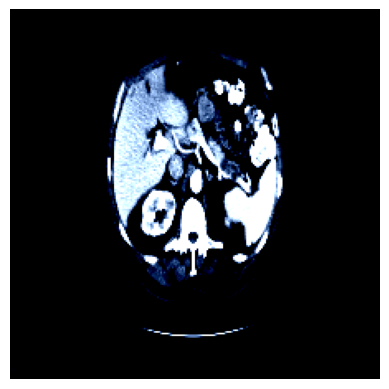

In [12]:
# ===============================
# Section 12: Case-level CNN Inference
# ===============================
import matplotlib.pyplot as plt

idx = 12  # selected test index
sample = test_dataset[idx]

image_tensor = sample["image"]      # CNN input
question_tensor = sample["question"]
gt_label = sample["answer"].item()

# Visualize image
plt.imshow(image_tensor.permute(1, 2, 0))
plt.axis("off")
plt.show()

# CNN
model.eval()
with torch.no_grad():
    img = image_tensor.unsqueeze(0).to(device)      # [1,3,224,224]
    ques = question_tensor.unsqueeze(0).to(device)  # [1,T]

    logits = model(img, ques)
    pred = logits.argmax(dim=1).item()

# inv_answer_vocab already defined in Section 10
cnn_answer = inv_answer_vocab[pred]

In [13]:
# ===============================
# Section 13: LLaVA Case-level Inference
# ===============================
# torch and to_pil_image already imported in Section 10

# 1. Image (from CNN dataset)
image_tensor = sample["image"]          # [3,224,224]
image_pil = to_pil_image(image_tensor.cpu())

# 2. Question (raw text)
question_text = "Is there ascites?"  # or selected_case["question"]

# 3. Prompt
prompt = f"USER: <image>\n{question_text}\nASSISTANT:"

# 4. Processor
inputs = llava_processor(
    text=prompt,
    images=image_pil,
    return_tensors="pt"
)

# Device alignment
for k, v in inputs.items():
    if isinstance(v, torch.Tensor):
        inputs[k] = v.to(llava_model.device)

# 5. Inference
with torch.no_grad():
    output = llava_model.generate(
        **inputs,
        max_new_tokens=40,
        do_sample=False
    )

# 6. Decode
raw_answer = llava_processor.decode(output[0], skip_special_tokens=True)
llava_answer = raw_answer.split("ASSISTANT:")[-1].strip()

In [14]:
# ===============================
# Section 14: Qualitative Case Analysis
# ===============================
print("="*60)
print("SECTION 14: QUALITATIVE CASE ANALYSIS")
print("="*60)

case_results = []

# Only analyze yes/no cases (since CNN is trained on yes/no only)
yn_selected = [x for x in selected if x["answer_type"].lower() == "closed" and x["answer"].lower() in ["yes", "no"]]

print(f"\nAnalyzing {len(yn_selected)} yes/no cases from selected samples...\n")

for i, x in enumerate(yn_selected):
    # Find this sample in test_dataset by matching question and image
    dataset_idx = None
    for idx, sample_dict in enumerate(test_dataset.samples):
        if sample_dict["question"] == x["question"] and sample_dict["image_name"] == x["image_name"]:
            dataset_idx = idx
            break
    
    if dataset_idx is None:
        print(f"⚠️  Case {i+1}: Not found in yes/no test set, skipping")
        continue
        
    sample = test_dataset[dataset_idx]
    
    # CNN inference
    model.eval()
    with torch.no_grad():
        img = sample["image"].unsqueeze(0).to(device)
        ques = sample["question"].unsqueeze(0).to(device)
        pred = model(img, ques).argmax(1).item()
    cnn_pred = inv_answer_vocab[pred]

    # LLaVA inference
    image_pil = to_pil_image(sample["image"].cpu())
    question_text = x["question"]
    gt = x["answer"]

    prompt = f"USER: <image>\n{question_text}\nASSISTANT:"
    inputs = llava_processor(text=prompt, images=image_pil, return_tensors="pt")
    for k, v in inputs.items():
        if isinstance(v, torch.Tensor):
            inputs[k] = v.to(llava_model.device)

    with torch.no_grad():
        output = llava_model.generate(**inputs, max_new_tokens=40)

    raw = llava_processor.decode(output[0], skip_special_tokens=True)
    llava_pred = raw.split("ASSISTANT:")[-1].strip()

    case_results.append({
        "case": i + 1,
        "type": x["question_type"],
        "question": question_text,
        "gt": gt,
        "cnn": cnn_pred,
        "llava": llava_pred
    })
    
    print(f"✓ Case {i+1} ({x['question_type']}): {question_text[:50]}...")

print(f"\n{'='*60}")
print(f"Successfully analyzed {len(case_results)} cases")
print(f"{'='*60}")

SECTION 14: QUALITATIVE CASE ANALYSIS

Analyzing 4 yes/no cases from selected samples...

✓ Case 1 (PRES): Is there ascites?...
✓ Case 2 (PRES): Is there a small bowel obstruction?...
✓ Case 3 (ORGAN): Is this a study of the chest?...
✓ Case 4 (SIZE): Is the cecum dilated...

Successfully analyzed 4 cases


In [15]:
# ===============================
# Section 15: Display Qualitative Results
# ===============================
# matplotlib.pyplot already imported in Section 12

print("\n" + "="*60)
print("QUALITATIVE RESULTS - CASE BY CASE ANALYSIS")
print("="*60 + "\n")

for r in case_results:
    print(f"{'='*60}")
    print(f"Case {r['case']} - Question Type: {r['type']}")
    print(f"{'='*60}")
    print(f"Question: {r['question']}")
    print(f"Ground Truth: {r['gt']}")
    print(f"\nModel Predictions:")
    print(f"  CNN-LSTM:  {r['cnn']}")
    print(f"  LLaVA-1.5: {r['llava']}")
    
    # Check correctness
    cnn_match = r['cnn'].lower() == r['gt'].lower()
    # For LLaVA, check if GT is contained in prediction or vice versa
    llava_match = r['gt'].lower() in r['llava'].lower() or r['llava'].lower() in r['gt'].lower()
    
    cnn_status = "✓ Correct" if cnn_match else "✗ Wrong"
    llava_status = "✓ Correct" if llava_match else "✗ Wrong"
    
    print(f"\nEvaluation:")
    print(f"  CNN-LSTM:  {cnn_status}")
    print(f"  LLaVA-1.5: {llava_status}")
    print()

# Summary statistics
cnn_correct_count = sum(1 for r in case_results if r['cnn'].lower() == r['gt'].lower())
llava_correct_count = sum(1 for r in case_results if r['gt'].lower() in r['llava'].lower() or r['llava'].lower() in r['gt'].lower())

print("="*60)
print("QUALITATIVE ANALYSIS SUMMARY")
print("="*60)
print(f"Total cases analyzed: {len(case_results)}")
print(f"CNN-LSTM correct: {cnn_correct_count}/{len(case_results)} ({cnn_correct_count/len(case_results)*100:.1f}%)")
print(f"LLaVA-1.5 correct: {llava_correct_count}/{len(case_results)} ({llava_correct_count/len(case_results)*100:.1f}%)")
print("="*60)


QUALITATIVE RESULTS - CASE BY CASE ANALYSIS

Case 1 - Question Type: PRES
Question: Is there ascites?
Ground Truth: No

Model Predictions:
  CNN-LSTM:  no
  LLaVA-1.5: Yes, there is ascites in the image.

Evaluation:
  CNN-LSTM:  ✓ Correct
  LLaVA-1.5: ✗ Wrong

Case 2 - Question Type: PRES
Question: Is there a small bowel obstruction?
Ground Truth: Yes

Model Predictions:
  CNN-LSTM:  yes
  LLaVA-1.5: Yes, there is a small bowel obstruction in the image.

Evaluation:
  CNN-LSTM:  ✓ Correct
  LLaVA-1.5: ✓ Correct

Case 3 - Question Type: ORGAN
Question: Is this a study of the chest?
Ground Truth: yes

Model Predictions:
  CNN-LSTM:  no
  LLaVA-1.5: Yes, this is a study of the chest, specifically focusing on the ribcage and the spine. The image shows a close-up view of the ribcage and spine

Evaluation:
  CNN-LSTM:  ✗ Wrong
  LLaVA-1.5: ✓ Correct

Case 4 - Question Type: SIZE
Question: Is the cecum dilated
Ground Truth: Yes

Model Predictions:
  CNN-LSTM:  yes
  LLaVA-1.5: Yes, the cecu

In [16]:
# ===============================
# Section 16: Comprehensive Analysis (All Metrics)
# ===============================
print("="*60)
print("SECTION 16: COMPREHENSIVE ANALYSIS")
print("="*60)
print("Collecting data for:")
print("  - Performance by question type")
print("  - Error case analysis")
print("  - Failure mode analysis")
print("="*60)

from collections import Counter, defaultdict

# Data structures for analysis
type_performance = defaultdict(lambda: {"cnn_correct": 0, "llava_correct": 0, "total": 0})
cnn_errors = []
llava_errors = []
both_errors = []
cnn_failure_patterns = {
    "by_question_type": Counter(),
    "by_organ": Counter(),
    "by_answer": Counter()
}
llava_failure_patterns = {
    "by_question_type": Counter(),
    "by_organ": Counter(),
    "by_answer": Counter()
}

print(f"\nProcessing {len(test_dataset)} yes/no test questions...")
print("This will take approximately 10-15 minutes...\n")

for dataset_idx in range(len(test_dataset)):
    sample = test_dataset[dataset_idx]
    original_sample = test_dataset.samples[dataset_idx]

    question_text = original_sample["question"]
    gt = original_sample["answer"].lower()
    qtype = original_sample["question_type"]
    organ = original_sample["image_organ"]

    # CNN inference
    model.eval()
    with torch.no_grad():
        img = sample["image"].unsqueeze(0).to(device)
        ques = sample["question"].unsqueeze(0).to(device)
        pred = model(img, ques).argmax(1).item()
    cnn_pred = inv_answer_vocab[pred]

    # LLaVA inference
    image_pil = to_pil_image(sample["image"].cpu())
    prompt = f"USER: <image>\n{question_text}\nAnswer strictly with Yes or No.\nASSISTANT:"

    inputs = llava_processor(text=prompt, images=image_pil, return_tensors="pt")
    for k, v in inputs.items():
        if isinstance(v, torch.Tensor):
            inputs[k] = v.to(llava_model.device)

    with torch.no_grad():
        output = llava_model.generate(**inputs, max_new_tokens=10)

    raw = llava_processor.decode(output[0], skip_special_tokens=True)
    llava_pred = "yes" if "yes" in raw.lower() else ("no" if "no" in raw.lower() else "unknown")

    # Update all metrics
    cnn_correct = (cnn_pred == gt)
    llava_correct = (llava_pred == gt)

    # Performance by type
    type_performance[qtype]["total"] += 1
    if cnn_correct:
        type_performance[qtype]["cnn_correct"] += 1
    if llava_correct:
        type_performance[qtype]["llava_correct"] += 1

    # Error cases
    error_case = {
        "question": question_text,
        "gt": gt,
        "cnn_pred": cnn_pred,
        "llava_pred": llava_pred,
        "qtype": qtype,
        "organ": organ
    }

    if not cnn_correct and not llava_correct:
        both_errors.append(error_case)
    elif not cnn_correct:
        cnn_errors.append(error_case)
    elif not llava_correct:
        llava_errors.append(error_case)

    # Failure patterns
    if not cnn_correct:
        cnn_failure_patterns["by_question_type"][qtype] += 1
        cnn_failure_patterns["by_organ"][organ] += 1
        cnn_failure_patterns["by_answer"][gt] += 1

    if not llava_correct:
        llava_failure_patterns["by_question_type"][qtype] += 1
        llava_failure_patterns["by_organ"][organ] += 1
        llava_failure_patterns["by_answer"][gt] += 1

    if (dataset_idx + 1) % 20 == 0:
        print(f"  Progress: {dataset_idx + 1}/{len(test_dataset)} samples ({(dataset_idx + 1)/len(test_dataset)*100:.1f}%)")

print(f"\n✓ Analysis complete!")
print("="*60)

SECTION 16: COMPREHENSIVE ANALYSIS
  - Performance by question type
  - Error case analysis
  - Failure mode analysis

Processing 240 yes/no test questions...
This will take approximately 10-15 minutes...

  Progress: 20/240 samples (8.3%)
  Progress: 40/240 samples (16.7%)
  Progress: 60/240 samples (25.0%)
  Progress: 80/240 samples (33.3%)
  Progress: 100/240 samples (41.7%)
  Progress: 120/240 samples (50.0%)
  Progress: 140/240 samples (58.3%)
  Progress: 160/240 samples (66.7%)
  Progress: 180/240 samples (75.0%)
  Progress: 200/240 samples (83.3%)
  Progress: 220/240 samples (91.7%)
  Progress: 240/240 samples (100.0%)

✓ Analysis complete!



PART 1: PERFORMANCE BY QUESTION TYPE

Question Type   Count    CNN Acc         LLaVA Acc      
----------------------------------------------------------------------
ABN             24        62.50% ( 15)    50.00% ( 12)
ATTRIB          8         50.00% (  4)    75.00% (  6)
COLOR           8         50.00% (  4)    75.00% (  6)
COUNT           2         50.00% (  1)     0.00% (  0)
MODALITY        19        84.21% ( 16)    63.16% ( 12)
ORGAN           5         20.00% (  1)   100.00% (  5)
OTHER           9         55.56% (  5)    88.89% (  8)
PLANE           10        60.00% (  6)    60.00% (  6)
POS             5         60.00% (  3)     0.00% (  0)
POS, PRES       2          0.00% (  0)   100.00% (  2)
PRES            109       68.81% ( 75)    36.70% ( 40)
SIZE            38        68.42% ( 26)    44.74% ( 17)
SIZE, PRES      1        100.00% (  1)   100.00% (  1)
----------------------------------------------------------------------
OVERALL         240       65.42% (157)    47.92

C:\Users\ACER\AppData\Local\Temp\ipykernel_8272\3545619839.py:94: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(qtypes, rotation=45, ha='right')


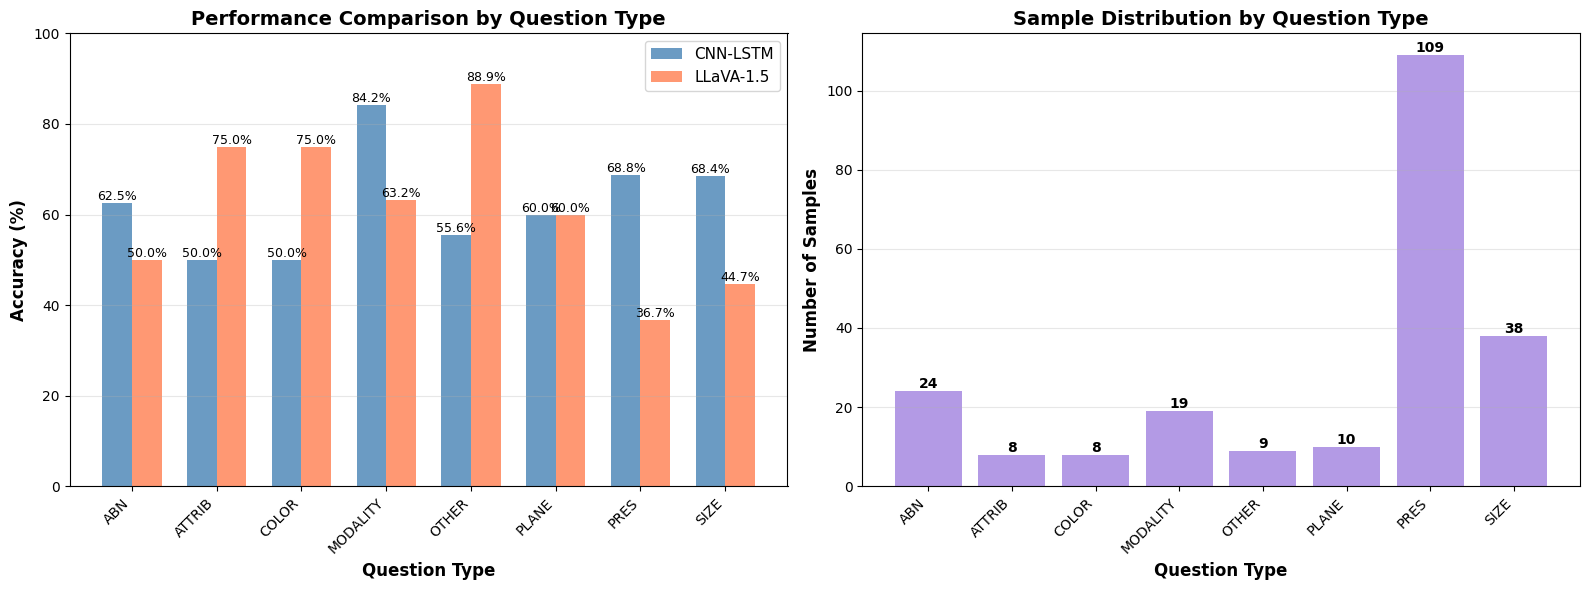

✓ Saved: performance_by_question_type.png


PART 2: ERROR CASE ANALYSIS

Total samples analyzed: 240

📉 Error Distribution:
   CNN-only errors:     47 ( 19.6%)
   LLaVA-only errors:   89 ( 37.1%)
   Both wrong:          36 ( 15.0%)
   Both correct:        68 ( 28.3%)


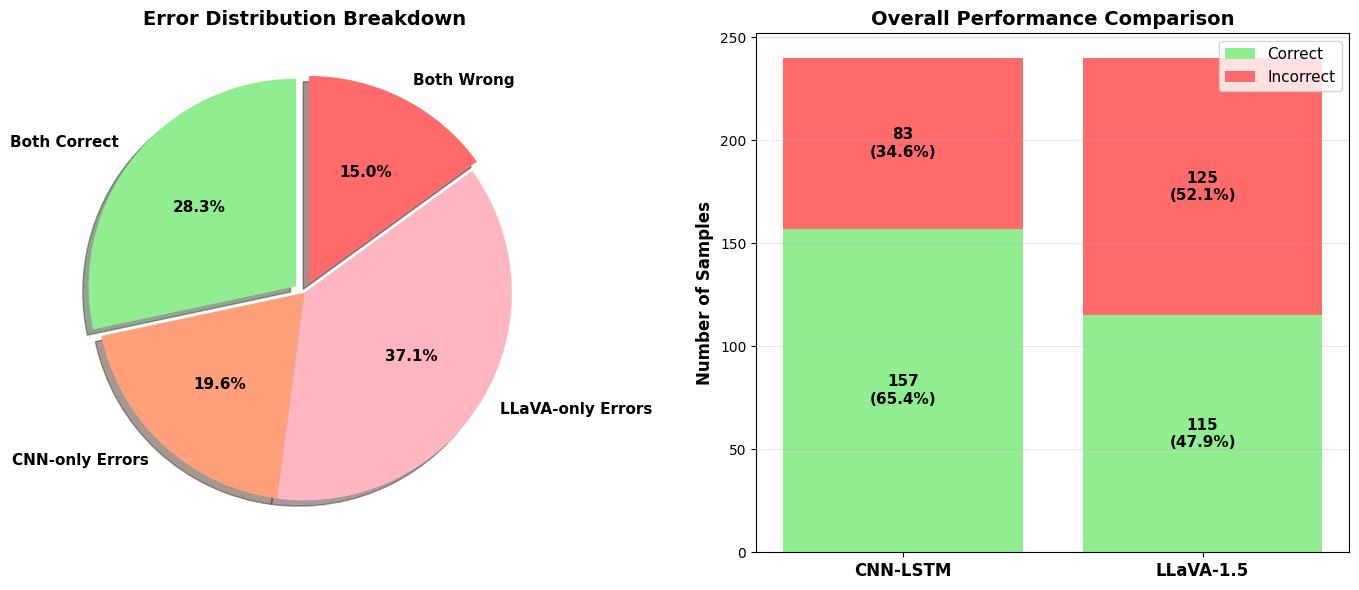


✓ Saved: error_distribution_analysis.png

──────────────────────────────────────────────────────────────────────
📋 Examples where BOTH models failed:
──────────────────────────────────────────────────────────────────────

[1] Type: PRES | Organ: CHEST
    Q: Is there blunting of the costovertebral angles?
    GT: 'no' | CNN: 'yes' | LLaVA: 'yes'

[2] Type: PRES | Organ: CHEST
    Q: Is there a pneumothorax?
    GT: 'no' | CNN: 'yes' | LLaVA: 'yes'

[3] Type: PLANE | Organ: CHEST
    Q: Is this an anterior-posterior image
    GT: 'no' | CNN: 'yes' | LLaVA: 'yes'

[4] Type: SIZE | Organ: ABD
    Q: Is the gallbladder large in size?
    GT: 'no' | CNN: 'yes' | LLaVA: 'yes'

[5] Type: SIZE | Organ: ABD
    Q: Is the gallbladder distended?
    GT: 'no' | CNN: 'yes' | LLaVA: 'yes'

──────────────────────────────────────────────────────────────────────
📋 Examples where LLaVA succeeded but CNN failed:
──────────────────────────────────────────────────────────────────────

[1] Type: PRES
    Q

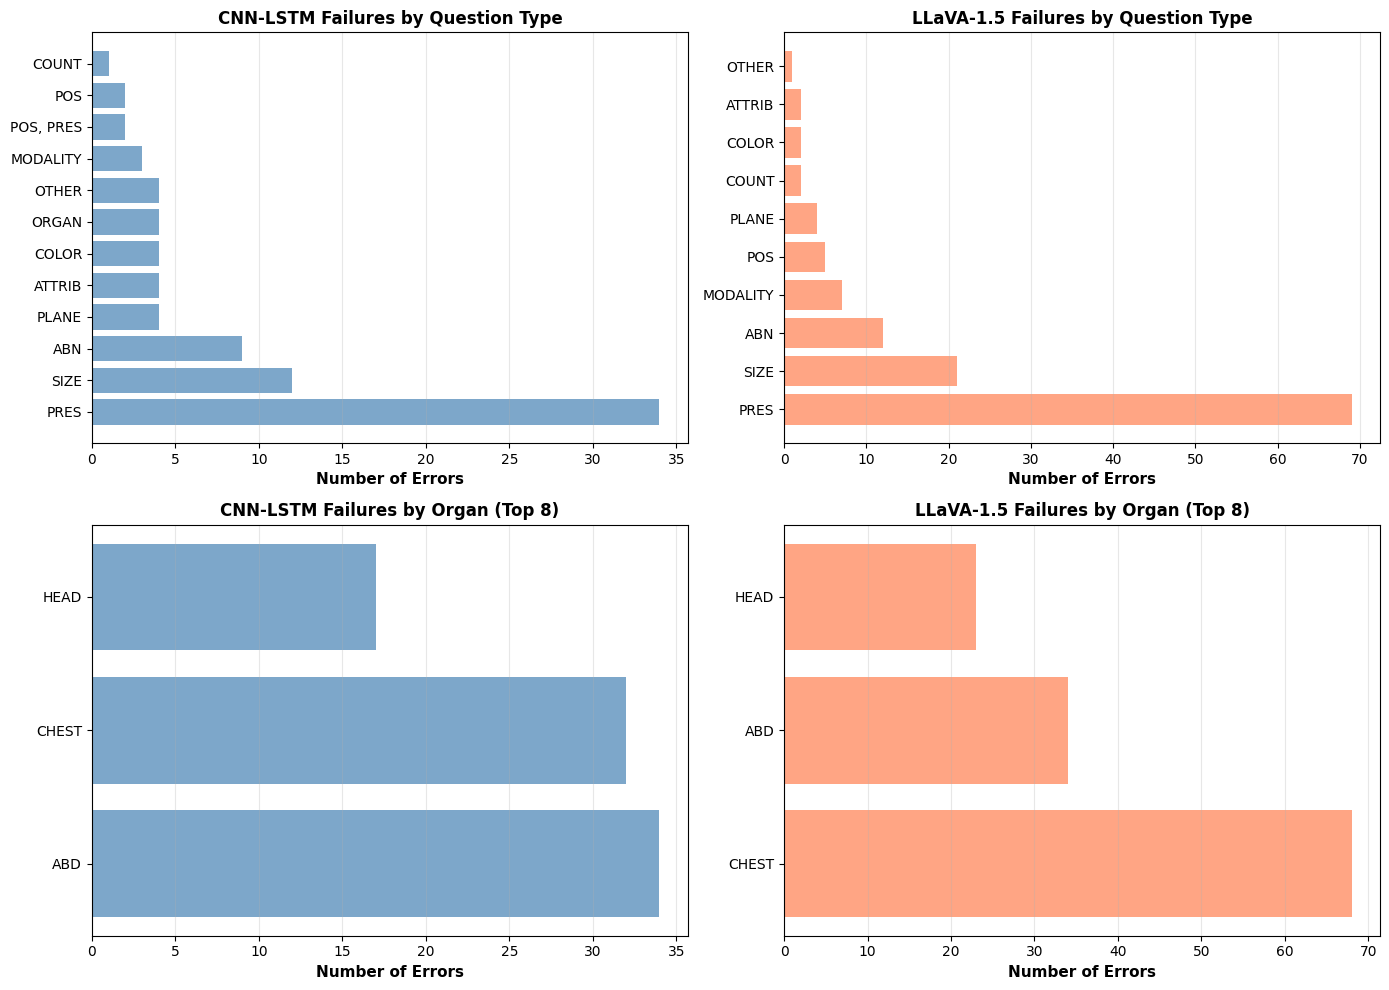


✓ Saved: failure_pattern_analysis.png

✅ COMPREHENSIVE ANALYSIS COMPLETE

Generated visualizations:
  1. performance_by_question_type.png
  2. error_distribution_analysis.png
  3. failure_pattern_analysis.png


In [17]:
# ===============================
# Section 17: Display Comprehensive Results (With Visualization)
# ===============================
import numpy as np

# ============================================================
# PART 1: PERFORMANCE BY QUESTION TYPE
# ============================================================
print("\n" + "="*70)
print("PART 1: PERFORMANCE BY QUESTION TYPE")
print("="*70 + "\n")

print(f"{'Question Type':<15} {'Count':<8} {'CNN Acc':<15} {'LLaVA Acc':<15}")
print("-" * 70)

for qtype in sorted(type_performance.keys()):
    stats = type_performance[qtype]
    total = stats["total"]
    cnn_acc = stats["cnn_correct"] / total if total > 0 else 0
    llava_acc = stats["llava_correct"] / total if total > 0 else 0

    print(f"{qtype:<15} {total:<8} {cnn_acc*100:>6.2f}% ({stats['cnn_correct']:>3})   {llava_acc*100:>6.2f}% ({stats['llava_correct']:>3})")

print("-" * 70)

# Overall
total_all = sum(s["total"] for s in type_performance.values())
cnn_correct_all = sum(s["cnn_correct"] for s in type_performance.values())
llava_correct_all = sum(s["llava_correct"] for s in type_performance.values())

print(f"{'OVERALL':<15} {total_all:<8} {cnn_correct_all/total_all*100:>6.2f}% ({cnn_correct_all:>3})   {llava_correct_all/total_all*100:>6.2f}% ({llava_correct_all:>3})")
print("="*70)

# Best/Worst analysis
cnn_best = max(type_performance.items(), key=lambda x: x[1]["cnn_correct"]/x[1]["total"] if x[1]["total"] > 5 else 0)
cnn_worst = min(type_performance.items(), key=lambda x: x[1]["cnn_correct"]/x[1]["total"] if x[1]["total"] > 5 else 1)

print(f"\n📊 CNN-LSTM Performance:")
print(f"   Best:  {cnn_best[0]} - {cnn_best[1]['cnn_correct']/cnn_best[1]['total']*100:.1f}% ({cnn_best[1]['total']} samples)")
print(f"   Worst: {cnn_worst[0]} - {cnn_worst[1]['cnn_correct']/cnn_worst[1]['total']*100:.1f}% ({cnn_worst[1]['total']} samples)")

llava_best = max(type_performance.items(), key=lambda x: x[1]["llava_correct"]/x[1]["total"] if x[1]["total"] > 5 else 0)
llava_worst = min(type_performance.items(), key=lambda x: x[1]["llava_correct"]/x[1]["total"] if x[1]["total"] > 5 else 1)

print(f"\n📊 LLaVA-1.5 Performance:")
print(f"   Best:  {llava_best[0]} - {llava_best[1]['llava_correct']/llava_best[1]['total']*100:.1f}% ({llava_best[1]['total']} samples)")
print(f"   Worst: {llava_worst[0]} - {llava_worst[1]['llava_correct']/llava_worst[1]['total']*100:.1f}% ({llava_worst[1]['total']} samples)")


# ============================================================
# VISUALIZATION 1: Bar Chart - Performance by Question Type
# ============================================================
print("\n\n📊 Generating visualization...")

# Prepare data for plotting (only types with >5 samples)
qtypes_filtered = {k: v for k, v in type_performance.items() if v["total"] > 5}
qtypes = sorted(qtypes_filtered.keys())
cnn_accs = [qtypes_filtered[q]["cnn_correct"] / qtypes_filtered[q]["total"] * 100 for q in qtypes]
llava_accs = [qtypes_filtered[q]["llava_correct"] / qtypes_filtered[q]["total"] * 100 for q in qtypes]
counts = [qtypes_filtered[q]["total"] for q in qtypes]

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Grouped bar chart
x = np.arange(len(qtypes))
width = 0.35

bars1 = ax1.bar(x - width/2, cnn_accs, width, label='CNN-LSTM', alpha=0.8, color='steelblue')
bars2 = ax1.bar(x + width/2, llava_accs, width, label='LLaVA-1.5', alpha=0.8, color='coral')

ax1.set_xlabel('Question Type', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Performance Comparison by Question Type', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(qtypes, rotation=45, ha='right')
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 100)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9)

# Subplot 2: Sample distribution
ax2.bar(qtypes, counts, alpha=0.7, color='mediumpurple')
ax2.set_xlabel('Question Type', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax2.set_title('Sample Distribution by Question Type', fontsize=14, fontweight='bold')
ax2.set_xticklabels(qtypes, rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for i, (qtype, count) in enumerate(zip(qtypes, counts)):
    ax2.text(i, count, str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('performance_by_question_type.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: performance_by_question_type.png")


# ============================================================
# PART 2: ERROR CASE ANALYSIS
# ============================================================
print("\n\n" + "="*70)
print("PART 2: ERROR CASE ANALYSIS")
print("="*70 + "\n")

total_samples = len(test_dataset)
cnn_only_errors = len(cnn_errors)
llava_only_errors = len(llava_errors)
both_errors_count = len(both_errors)
both_correct = total_samples - cnn_only_errors - llava_only_errors - both_errors_count

print(f"Total samples analyzed: {total_samples}")
print(f"\n📉 Error Distribution:")
print(f"   CNN-only errors:   {cnn_only_errors:>4} ({cnn_only_errors/total_samples*100:>5.1f}%)")
print(f"   LLaVA-only errors: {llava_only_errors:>4} ({llava_only_errors/total_samples*100:>5.1f}%)")
print(f"   Both wrong:        {both_errors_count:>4} ({both_errors_count/total_samples*100:>5.1f}%)")
print(f"   Both correct:      {both_correct:>4} ({both_correct/total_samples*100:>5.1f}%)")

# Visualization 2: Error distribution pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart
labels = ['Both Correct', 'CNN-only Errors', 'LLaVA-only Errors', 'Both Wrong']
sizes = [both_correct, cnn_only_errors, llava_only_errors, both_errors_count]
colors = ['#90EE90', '#FFA07A', '#FFB6C1', '#FF6B6B']
explode = (0.05, 0, 0, 0.05)

ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax1.set_title('Error Distribution Breakdown', fontsize=14, fontweight='bold')

# Stacked bar chart
models = ['CNN-LSTM', 'LLaVA-1.5']
correct = [cnn_correct_all, llava_correct_all]
incorrect = [total_samples - cnn_correct_all, total_samples - llava_correct_all]

x_pos = np.arange(len(models))
p1 = ax2.bar(x_pos, correct, color='#90EE90', label='Correct')
p2 = ax2.bar(x_pos, incorrect, bottom=correct, color='#FF6B6B', label='Incorrect')

ax2.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax2.set_title('Overall Performance Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(models, fontsize=12, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(axis='y', alpha=0.3)

# Add percentage labels
for i, (c, inc) in enumerate(zip(correct, incorrect)):
    total_i = c + inc
    ax2.text(i, c/2, f'{c}\n({c/total_i*100:.1f}%)',
             ha='center', va='center', fontsize=11, fontweight='bold')
    ax2.text(i, c + inc/2, f'{inc}\n({inc/total_i*100:.1f}%)',
             ha='center', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('error_distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: error_distribution_analysis.png")

# Example error cases
print(f"\n{'─'*70}")
print("📋 Examples where BOTH models failed:")
print(f"{'─'*70}")
for i, err in enumerate(both_errors[:5]):
    print(f"\n[{i+1}] Type: {err['qtype']} | Organ: {err['organ']}")
    print(f"    Q: {err['question']}")
    print(f"    GT: '{err['gt']}' | CNN: '{err['cnn_pred']}' | LLaVA: '{err['llava_pred']}'")

print(f"\n{'─'*70}")
print("📋 Examples where LLaVA succeeded but CNN failed:")
print(f"{'─'*70}")
for i, err in enumerate(cnn_errors[:5]):
    print(f"\n[{i+1}] Type: {err['qtype']}")
    print(f"    Q: {err['question']}")
    print(f"    GT: '{err['gt']}' | CNN: '{err['cnn_pred']}' ✗ | LLaVA: '{err['llava_pred']}' ✓")

print(f"\n{'─'*70}")
print("📋 Examples where CNN succeeded but LLaVA failed:")
print(f"{'─'*70}")
for i, err in enumerate(llava_errors[:5]):
    print(f"\n[{i+1}] Type: {err['qtype']}")
    print(f"    Q: {err['question']}")
    print(f"    GT: '{err['gt']}' | CNN: '{err['cnn_pred']}' ✓ | LLaVA: '{err['llava_pred']}' ✗")


# ============================================================
# PART 3: FAILURE MODE ANALYSIS
# ============================================================
print("\n\n" + "="*70)
print("PART 3: FAILURE MODE ANALYSIS")
print("="*70)

print("\n🔍 CNN-LSTM Failure Patterns:")
print("   By Question Type:")
for qtype, count in cnn_failure_patterns["by_question_type"].most_common():
    pct = count / type_performance[qtype]["total"] * 100 if type_performance[qtype]["total"] > 0 else 0
    print(f"      {qtype:<12}: {count:>3} errors ({pct:>5.1f}% of {qtype} questions)")

print("\n   By Organ:")
for organ, count in cnn_failure_patterns["by_organ"].most_common():
    print(f"      {organ:<12}: {count:>3} errors")

cnn_yes_errors = cnn_failure_patterns["by_answer"].get("yes", 0)
cnn_no_errors = cnn_failure_patterns["by_answer"].get("no", 0)
print(f"\n   Prediction Bias:")
print(f"      Failed on 'yes' answers: {cnn_yes_errors}")
print(f"      Failed on 'no' answers:  {cnn_no_errors}")
if cnn_yes_errors > cnn_no_errors:
    print(f"      → CNN tends to predict 'no' even when answer is 'yes'")
else:
    print(f"      → CNN tends to predict 'yes' even when answer is 'no'")

print("\n" + "─"*70)
print("\n🔍 LLaVA-1.5 Failure Patterns:")
print("   By Question Type:")
for qtype, count in llava_failure_patterns["by_question_type"].most_common():
    pct = count / type_performance[qtype]["total"] * 100 if type_performance[qtype]["total"] > 0 else 0
    print(f"      {qtype:<12}: {count:>3} errors ({pct:>5.1f}% of {qtype} questions)")

print("\n   By Organ:")
for organ, count in llava_failure_patterns["by_organ"].most_common():
    print(f"      {organ:<12}: {count:>3} errors")

llava_yes_errors = llava_failure_patterns["by_answer"].get("yes", 0)
llava_no_errors = llava_failure_patterns["by_answer"].get("no", 0)
print(f"\n   Prediction Bias:")
print(f"      Failed on 'yes' answers: {llava_yes_errors}")
print(f"      Failed on 'no' answers:  {llava_no_errors}")
if llava_yes_errors > llava_no_errors:
    print(f"      → LLaVA tends to predict 'no' even when answer is 'yes'")
else:
    print(f"      → LLaVA tends to predict 'yes' even when answer is 'no'")

# Visualization 3: Failure patterns comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# CNN failure by question type
ax = axes[0, 0]
cnn_fail_qtypes = dict(cnn_failure_patterns["by_question_type"].most_common())
if cnn_fail_qtypes:
    ax.barh(list(cnn_fail_qtypes.keys()), list(cnn_fail_qtypes.values()), color='steelblue', alpha=0.7)
    ax.set_xlabel('Number of Errors', fontsize=11, fontweight='bold')
    ax.set_title('CNN-LSTM Failures by Question Type', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

# LLaVA failure by question type
ax = axes[0, 1]
llava_fail_qtypes = dict(llava_failure_patterns["by_question_type"].most_common())
if llava_fail_qtypes:
    ax.barh(list(llava_fail_qtypes.keys()), list(llava_fail_qtypes.values()), color='coral', alpha=0.7)
    ax.set_xlabel('Number of Errors', fontsize=11, fontweight='bold')
    ax.set_title('LLaVA-1.5 Failures by Question Type', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

# CNN failure by organ
ax = axes[1, 0]
cnn_fail_organs = dict(list(cnn_failure_patterns["by_organ"].most_common())[:8])
if cnn_fail_organs:
    ax.barh(list(cnn_fail_organs.keys()), list(cnn_fail_organs.values()), color='steelblue', alpha=0.7)
    ax.set_xlabel('Number of Errors', fontsize=11, fontweight='bold')
    ax.set_title('CNN-LSTM Failures by Organ (Top 8)', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

# LLaVA failure by organ
ax = axes[1, 1]
llava_fail_organs = dict(list(llava_failure_patterns["by_organ"].most_common())[:8])
if llava_fail_organs:
    ax.barh(list(llava_fail_organs.keys()), list(llava_fail_organs.values()), color='coral', alpha=0.7)
    ax.set_xlabel('Number of Errors', fontsize=11, fontweight='bold')
    ax.set_title('LLaVA-1.5 Failures by Organ (Top 8)', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('failure_pattern_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: failure_pattern_analysis.png")

print("\n" + "="*70)
print("✅ COMPREHENSIVE ANALYSIS COMPLETE")
print("="*70)
print("\nGenerated visualizations:")
print("  1. performance_by_question_type.png")
print("  2. error_distribution_analysis.png")
print("  3. failure_pattern_analysis.png")
print("="*70)

In [18]:
# ===============================
# Section 18: Open-Ended Question Evaluation
# ===============================
print("\n" + "="*70)
print("SECTION 18: OPEN-ENDED QUESTION EVALUATION (LLaVA only)")
print("="*70)
print("\nNote: CNN-LSTM is trained only for yes/no questions.")
print("Open-ended evaluation is performed using LLaVA-1.5 only.")
print("="*70)

# Filter open-ended questions from test set
open_ended_test = [
    x for x in test_data
    if x["answer_type"].lower() == "open"
]

print(f"\nTotal open-ended questions in test set: {len(open_ended_test)}")

# Sample for evaluation
# random already imported in Section 11
import random
from PIL import Image
import os

random.seed(42)
NUM_OPEN_SAMPLES = min(30, len(open_ended_test))
sampled_open = random.sample(open_ended_test, NUM_OPEN_SAMPLES)

print(f"Evaluating {NUM_OPEN_SAMPLES} sampled open-ended questions...")
print(f"Estimated time: ~{NUM_OPEN_SAMPLES * 3 / 60:.1f} minutes\n")

open_results = []

for i, x in enumerate(sampled_open):
    # Load image
    image_path = os.path.join(r"D:\UM\WOA7015 ADVANCE MACHINE LEARNING\AA\VQA_RAD Image Folder", x["image_name"])

    try:
        image = Image.open(image_path).convert("RGB")
    except:
        print(f"  ⚠️  Sample {i+1}: Image not found, skipping")
        continue

    question_text = x["question"]
    gt_answer = x["answer"]

    # LLaVA inference
    prompt = f"USER: <image>\n{question_text}\nASSISTANT:"

    inputs = llava_processor(text=prompt, images=image, return_tensors="pt")
    for k, v in inputs.items():
        if isinstance(v, torch.Tensor):
            inputs[k] = v.to(llava_model.device)

    with torch.no_grad():
        output = llava_model.generate(**inputs, max_new_tokens=50)

    raw = llava_processor.decode(output[0], skip_special_tokens=True)
    llava_answer = raw.split("ASSISTANT:")[-1].strip()

    open_results.append({
        "question_type": x["question_type"],
        "question": question_text,
        "ground_truth": gt_answer,
        "llava_answer": llava_answer,
        "image_organ": x["image_organ"]
    })

    if (i+1) % 5 == 0:
        print(f"  Processed {i+1}/{NUM_OPEN_SAMPLES} samples...")

print(f"\n✓ Open-ended evaluation complete!")

# Display results by question type
print("\n" + "="*70)
print("OPEN-ENDED EVALUATION RESULTS")
print("="*70)

# defaultdict already imported in Section 11
by_type = defaultdict(list)
for r in open_results:
    by_type[r["question_type"]].append(r)

for qtype, results in sorted(by_type.items()):
    print(f"\n{'─'*70}")
    print(f"📋 {qtype} Questions ({len(results)} samples):")
    print(f"{'─'*70}")

    for idx, r in enumerate(results[:3]):  # Show first 3 examples of each type
        print(f"\n[Example {idx+1}]")
        print(f"Organ: {r['image_organ']}")
        print(f"Q:  {r['question']}")
        print(f"GT: {r['ground_truth']}")
        print(f"LLaVA: {r['llava_answer']}")

# Qualitative assessment summary
print("\n" + "="*70)
print("QUALITATIVE ASSESSMENT")
print("="*70)
print("""
⚠️  Note on Evaluation Metrics:

For open-ended medical questions, automated metrics like BLEU or ROUGE
are insufficient because:

1. Multiple valid phrasings exist for the same clinical finding
2. Semantic correctness matters more than word overlap
3. Medical accuracy requires domain expertise to verify

Recommended Evaluation Approach:
- Manual review by medical professionals
- Assessment of factual correctness
- Evaluation of clinical relevance
- Comparison of semantic meaning vs. exact wording

For this study, we provide qualitative examples showing LLaVA-1.5's
ability to generate medically coherent responses to open-ended questions.
Quantitative evaluation would require expert clinical annotation.
""")

print("="*70)
print(f"Total open-ended samples evaluated: {len(open_results)}")
print(f"Question types covered: {len(by_type)}")
print("="*70)


SECTION 18: OPEN-ENDED QUESTION EVALUATION (LLaVA only)

Note: CNN-LSTM is trained only for yes/no questions.
Open-ended evaluation is performed using LLaVA-1.5 only.

Total open-ended questions in test set: 175
Evaluating 30 sampled open-ended questions...
Estimated time: ~1.5 minutes

  Processed 5/30 samples...
  Processed 10/30 samples...
  Processed 15/30 samples...
  Processed 20/30 samples...
  Processed 25/30 samples...
  Processed 30/30 samples...

✓ Open-ended evaluation complete!

OPEN-ENDED EVALUATION RESULTS

──────────────────────────────────────────────────────────────────────
📋 COUNT Questions (1 samples):
──────────────────────────────────────────────────────────────────────

[Example 1]
Organ: ABD
Q:  How many kidneys are in this image?
GT: 2
LLaVA: There are two kidneys in this image.

──────────────────────────────────────────────────────────────────────
📋 MODALITY Questions (2 samples):
──────────────────────────────────────────────────────────────────────

[Examp